In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imp import reload
import gbeflow

# Load data from original test vector field

In [2]:
df = gbeflow.tidy_vector_data('original')

Convert to array based format

In [3]:
%%time
tt,xx,yy,vx,vy = gbeflow.reshape_vector_data(df)

CPU times: user 3.24 s, sys: 672 ms, total: 3.91 s
Wall time: 2.05 s


# Import corresponding brightfield data

In [4]:
hst = gbeflow.read_hyperstack('../data/wt_gbe_20180110_mask.h5')

In [10]:
hst.shape

(167, 1024, 1024)

# Pick a starting point in first timepoint

In [13]:
ax.shape

(2,)

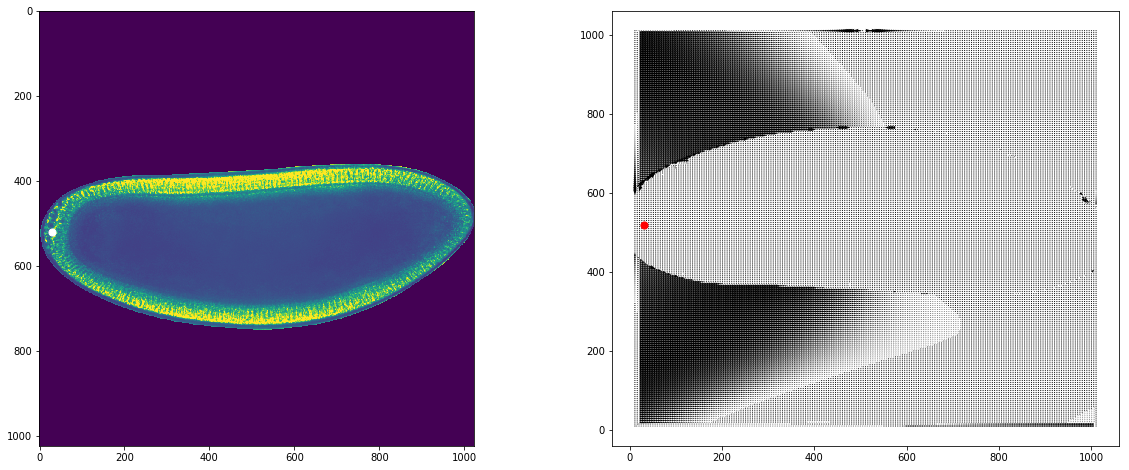

In [31]:
t = 1
fig,ax = plt.subplots(1,2,figsize=(20,8))
plt.quiver(xx[t],yy[t],vx[t],vy[t])
ax[0].imshow(hst[t])
ax[0].scatter(30,520,c='w',s=50)
ax[1].scatter(30,520,c='r',s=50)

In [5]:
start = [30,520]

# Synthetic particle method

Vig, D.K., Hamby, A.E., and Wolgemuth, C.W. (2016). On the Quantification of Cellular Velocity Fields. Biophys J 110, 1469–1475.

> We implement this method by randomly seeding 100 tracer particles into the first frame of a movie. The corresponding velocity field for the first image is then interpolated onto the particle positions and the position of the particle is updated using a forward Euler time-stepping routine. This process is repeated for all frames of the movie and any particles that flow out of the image domain are excluded.

In [6]:
from scipy.interpolate import interp2d

In [9]:
xx.shape

(166, 201, 201)

In [11]:
xx

array([[[  11,   11,   11, ...,   11,   11,   11],
        [  16,   16,   16, ...,   16,   16,   16],
        [  21,   21,   21, ...,   21,   21,   21],
        ...,
        [1001, 1001, 1001, ..., 1001, 1001, 1001],
        [1006, 1006, 1006, ..., 1006, 1006, 1006],
        [1011, 1011, 1011, ..., 1011, 1011, 1011]],

       [[  11,   11,   11, ...,   11,   11,   11],
        [  16,   16,   16, ...,   16,   16,   16],
        [  21,   21,   21, ...,   21,   21,   21],
        ...,
        [1001, 1001, 1001, ..., 1001, 1001, 1001],
        [1006, 1006, 1006, ..., 1006, 1006, 1006],
        [1011, 1011, 1011, ..., 1011, 1011, 1011]],

       [[  11,   11,   11, ...,   11,   11,   11],
        [  16,   16,   16, ...,   16,   16,   16],
        [  21,   21,   21, ...,   21,   21,   21],
        ...,
        [1001, 1001, 1001, ..., 1001, 1001, 1001],
        [1006, 1006, 1006, ..., 1006, 1006, 1006],
        [1011, 1011, 1011, ..., 1011, 1011, 1011]],

       ...,

       [[  11,   11,   1

Interpolating over the entire velocity field is rather time consuming. Maybe it would be more appropriate to look at a subset of the area based on the position of the point of interest.

Note: The xy position on the image does not correspond to the index of the vector arrays since they were sampled using a box rastered across the image.

In [14]:
%%time
sbst = np.s_[1,0:5,80:120]
vx_interp = interp2d(xx[sbst],yy[sbst],vx[sbst],kind='cubic')

CPU times: user 12.4 ms, sys: 3.4 ms, total: 15.8 ms
Wall time: 15.4 ms


/Users/morganschwartz/anaconda3/envs/python36/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=15,23 m=200 fp=0.719524 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [15]:
vx_interp(start[0],start[1])

array([0.01308914])

It looks like `interp2d` needs a minimum number of points in order to do a succesful interpolation. The calculation of the subset around the point of interest should incorporate this constraint.

Additionally, it seems that [scipy.interpolate.RectBivariateSpline](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.RectBivariateSpline.html#scipy.interpolate.RectBivariateSpline) performs faster than regular `interp2d` when used on meshgrid data.